In [124]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import ast
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from PIL import Image

from os import listdir

In [125]:
torch.cuda.is_available()

False

In [26]:
path = "data/"
data_path = path + "socal2.csv"
pics_path = path + "socal2/socal_pics/"
data = pd.read_csv(data_path)
prices = data["price"]

## Exploration

In [5]:
data.head(5)

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [8]:
data.describe()

,image_id,n_citi,bed,bath,sqft,price
count,15474.000000,15474.000000,15474.000000,15474.000000,15474.000000,1.547400e+04
mean,7736.500000,216.597518,3.506398,2.453251,2173.913209,7.031209e+05
std,4467.103368,112.372985,1.034838,0.958742,1025.339617,3.769762e+05
min,0.000000,0.000000,1.000000,0.000000,280.000000,1.950000e+05
25%,3868.250000,119.000000,3.000000,2.000000,1426.000000,4.450000e+05
50%,7736.500000,222.500000,3.000000,2.100000,1951.000000,6.390000e+05
75%,11604.750000,315.000000,4.000000,3.000000,2737.750000,8.349750e+05
max,15473.000000,414.000000,12.000000,36.000000,17667.000000,2.000000e+06


In [10]:
data.isna().value_counts()

image_id  street  citi   n_citi  bed    bath   sqft   price
False     False   False  False   False  False  False  False    15474
dtype: int64

In [4]:
data["street"].value_counts()

Address not provided        23
1930 W San Marcos Blvd       8
65565 Acoma Avenue           7
650 S Rancho Santa Fe Rd     5
315 Verbena Drive            5
                            ..
26134 Allentown Drive        1
239 N Scovell Avenue         1
22500 Mcpherson Road         1
875 Buick Avenue             1
4562 Eastbourne Bay          1
Name: street, Length: 12401, dtype: int64

In [6]:
data["n_citi"].value_counts()

320    707
207    388
193    312
175    305
310    274
      ... 
232      1
108      1
273      1
382      1
138      1
Name: n_citi, Length: 415, dtype: int64

In [7]:
data["bath"].value_counts()

2.0     5306
3.0     3291
2.1     2270
1.0     1386
3.1     1174
4.1      644
4.0      603
1.1      332
5.1      131
5.0      131
2.2       33
4.2       30
6.1       29
3.2       27
6.0       27
5.2       11
0.0       11
7.0       10
7.1        5
8.1        4
3.3        3
1.2        3
8.0        3
6.2        2
13.0       1
36.0       1
2.4        1
2.3        1
5.3        1
4.3        1
11.2       1
0.1        1
Name: bath, dtype: int64

In [11]:
data["image_id"].value_counts()

0        1
10276    1
10308    1
10309    1
10310    1
        ..
5162     1
5163     1
5164     1
5165     1
15473    1
Name: image_id, Length: 15474, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

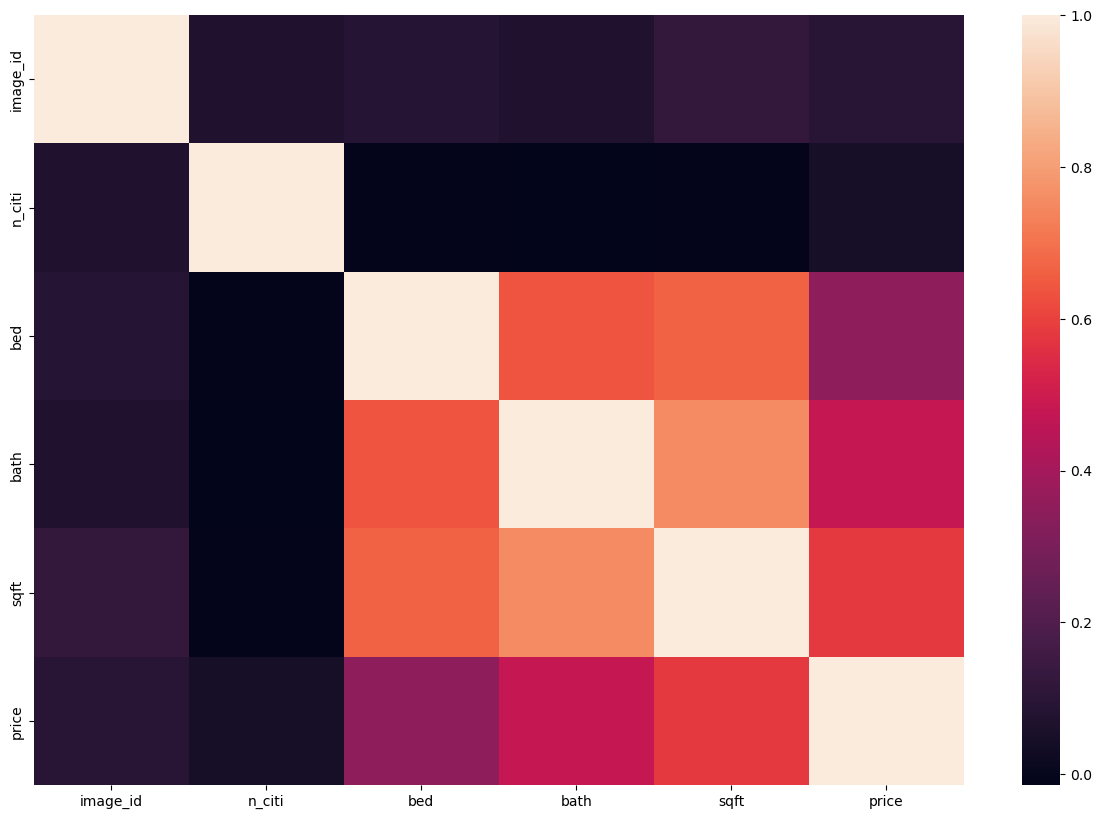

In [12]:
plt.figure(figsize=(15,10))
sb.heatmap(data.corr())
plt.show

In [13]:
def streudiagramm(x_achse, y_achse):
    plt.plot(x_achse, y_achse, 'o')
    m, b = np.polyfit(x_achse, y_achse, 1)
    plt.plot(x_achse, m*x_achse+b)

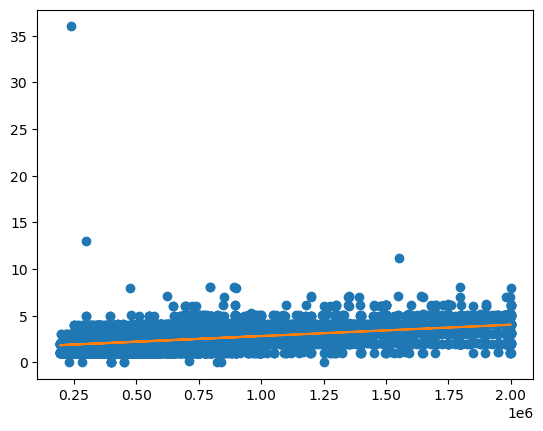

In [15]:
streudiagramm(prices, data["bath"])

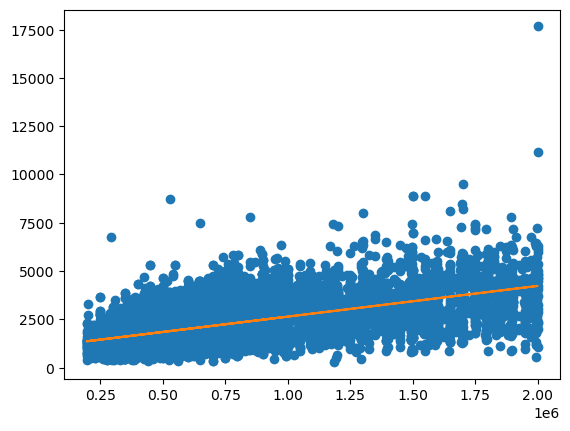

In [16]:
streudiagramm(prices, data["sqft"])

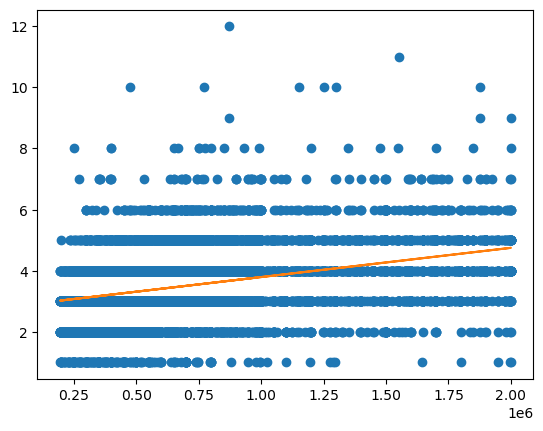

In [17]:
streudiagramm(prices, data["bed"])

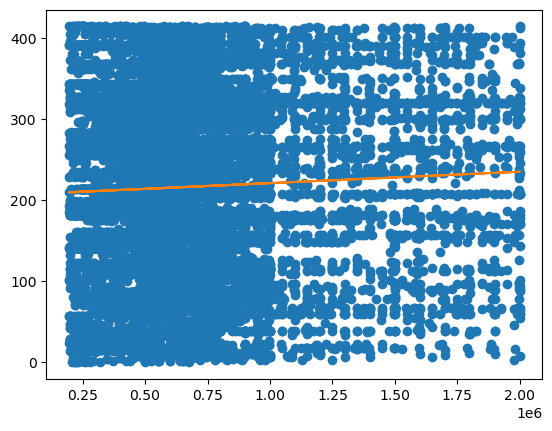

In [18]:
streudiagramm(prices, data["n_citi"])

#### mögliche Anpassungen:

In [20]:
# data = data.drop(["n_citi", "street", "citi"], axis=1)

## Bilder einlesen & bearbeiten

In [64]:
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(350),
    transforms.CenterCrop(350),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    normalize])

In [103]:
train_pics_list = []
train_data = []
prices = []
for file in tqdm(listdir(pics_path)):
    img = Image.open(pics_path + file)
    img_tensor = transform(img)
    #img_tensor = img_tensor.unsqueeze(0)

    train_pics_list.append(img_tensor)
    img_id = file[:-4]
    price = int(data[data["image_id"] == int(img_id)]["price"])
    prices.append(price)

    if len(train_pics_list) >= 64:
        train_data.append(((torch.stack(train_pics_list)), prices))
        labels = []
        train_pics_list = []
#print(train_data.shape)

100%|██████████| 15474/15474 [01:22<00:00, 187.42it/s]


In [113]:
class Netz(nn.Module):
    def __init__(self):
        super(Netz, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=4)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=4)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        print(x.size())
        exit()

model = Netz()
model.cuda()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
def train(epoch):
    model.train()
    batch_id = 0
    for data, price in train_data:
        data = data.cuda()
        price = torch.Tensor(prices).cuda()
        optimizer.zero_grad()
        out = model(data)
        criterion = F.mse_loss
        loss = criterion(out, price)
        loss.backward()
        optimizer.step()

        print("Train Epoch: {} [{}/{} ({:,0f}%)]\tLoss: {:.6f}".format(epoch, batch_id*len(data), len(train_data), 100. * batch_id / len(train_data, loss.data[0])))

        batch_id += 1

for epoch in range(1, 30):
    train(epoch)
